# Indice de Sentimiento Corporativo

En esta notebook se calcula el **índice de sentimiento corporativo**, un indicador del sentimiento económico de las cartas a los accionistas, que básicamente consiste en el porcentaje de párrafos optimistas de cada carta a los accionistas.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

En primer lugar se cargan los datos: los párrafos de las cartas a los accionistas, etiquetados por el modelo clasificador de sentimiento, donde un valor igual a 1 indica que el párrafo es optimista.

In [2]:
data = pd.read_csv('class_parrafos.csv')
data = data[['nombre', 'industria', 'autor', 'y_pred']]
data.columns = ['nombre', 'industria', 'autor', 'isc']
print(data.shape)
data.head()

(765, 4)


,nombre,industria,autor,isc
0,AES Gener,Energía,Presidente,1
1,AES Gener,Energía,Presidente,1
2,AES Gener,Energía,Presidente,1
3,AES Gener,Energía,Presidente,0
4,AES Gener,Energía,Presidente,1


Luego se promedian los valores de sentimiento por carta. Así, se obtiene el sentimiento promedio de cada carta. Este indice se denomina **'isc'**.

Luego se ordenan los datos de mayor a menor isc:
- Se muestran las cinco empresas con cartas más positivas.
- Y las cinco empresas con cartas menos positivas. En todos estos casos menos del 50% de los párrafos fue clasificado como positivo.

In [3]:
indices = data.groupby(['nombre', 'industria', 'autor']).mean()
indices = indices.reset_index()
indices.to_csv('01_indices.csv', index=False, encoding='utf-8-sig')
indices = indices.sort_values('isc', ascending=False)
display(indices.head())
display(indices.tail())

,nombre,industria,autor,isc
37,Ripley,Comercio,Presidente,1.000000
13,Cencosud,Comercio,Presidente,0.928571
26,Falabella,Comercio,Presidente,0.866667
17,Concha y Toro,Bebidas,Presidente,0.850000
38,SMU,Comercio,Gerente,0.833333


,nombre,industria,autor,isc
2,Aguas Andinas,Servicios Básicos,Presidente,0.384615
32,Itaú Corpbanca,Financiera,Presidente,0.375000
27,Grupo Security,Financiera,Presidente,0.363636
23,Engie,Energía,Presidente,0.363636
7,Banco de Chile,Financiera,Presidente,0.363636


A continuación se filtra la base de datos, manteniendo sólo las cartas escritas por presidentes de los directorios. Recordar que algunas empresas también tienen cartas escritas por los gerentes generales, pero son la minoría, mientras que todas tienen cartas escritas por los presidentes de los directorios, por eso, estas cartas se consideran más interesantes.

In [4]:
presidentes = indices[indices['autor']=='Presidente']
presidentes = presidentes.drop('autor', axis=1)
presidentes = presidentes.sort_values(by='isc', ignore_index=True)
presidentes.to_csv('02_presidentes.csv', index=False, encoding='utf-8-sig')
presidentes.head()

,nombre,industria,isc
0,Banco de Chile,Financiera,0.363636
1,Grupo Security,Financiera,0.363636
2,Engie,Energía,0.363636
3,Itaú Corpbanca,Financiera,0.375000
4,Aguas Andinas,Servicios Básicos,0.384615


El gráfico muestra el isc ordenado de mayor a menor. La línea roja corresponde al isc promedio. Así, es posible identificar empresas con cartas más y menos positivas que el promedio.

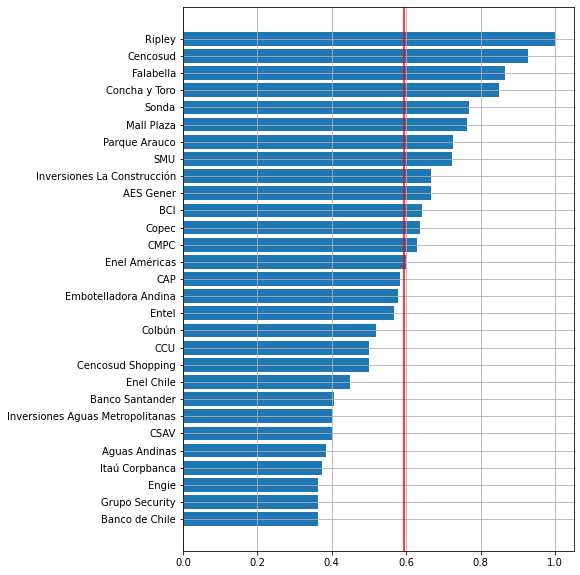

In [5]:
fig = plt.figure(figsize=(7,10))
plt.barh(presidentes.index, presidentes['isc'], tick_label=presidentes['nombre'])
plt.axvline(presidentes['isc'].mean(), color='red')
plt.grid()

A continuación, se repite el análisis pero con las cartas de los gerentes generales.

In [6]:
gerentes = indices[indices['autor']=='Gerente']
gerentes = gerentes.drop('autor', axis=1)
gerentes = gerentes.sort_values(by='isc', ignore_index=True)
gerentes.to_csv('03_gerentes.csv', index=False, encoding='utf-8-sig')
gerentes.head()

,nombre,industria,isc
0,Aguas Andinas,Servicios Básicos,0.400000
1,Itaú Corpbanca,Financiera,0.526316
2,Parque Arauco,Comercio,0.533333
3,Inversiones La Construcción,Financiera,0.545455
4,Engie,Energía,0.666667


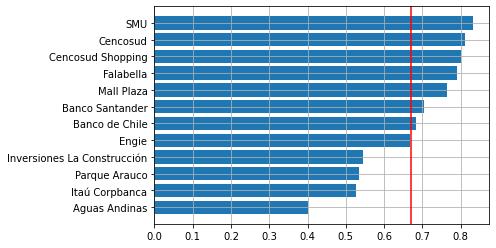

In [7]:
fig = plt.figure()
plt.barh(gerentes.index, gerentes['isc'], tick_label=gerentes['nombre'])
plt.axvline(gerentes['isc'].mean(), color='red')
plt.grid()

El siguiente análisis compara el sentimiento de las cartas de los presidentes y gerentes generales, usando sólo las empresas en que se encuentran cartas de ambos. 

Esto es interesante, ya que el gerente general debiera conocer en mayor profundidad el estado de la compañía o sus proyecciones, pero los directores debieran tener una visión más global, de la empresa, sector económico y economía nacional, y de más largo plazo.

In [8]:
gp = gerentes.merge(presidentes, on='nombre', how='left')
gp = gp[['nombre', 'industria_x', 'isc_x', 'isc_y']]
gp.columns = ['nombre', 'industria', 'gerentes', 'presidentes']
gp

,nombre,industria,gerentes,presidentes
0,Aguas Andinas,Servicios Básicos,0.400000,0.384615
1,Itaú Corpbanca,Financiera,0.526316,0.375000
2,Parque Arauco,Comercio,0.533333,0.727273
3,Inversiones La Construcción,Financiera,0.545455,0.666667
4,Engie,Energía,0.666667,0.363636
5,Banco de Chile,Financiera,0.684211,0.363636
6,Banco Santander,Financiera,0.703704,0.406250
7,Mall Plaza,Comercio,0.764706,0.764706
8,Falabella,Comercio,0.789474,0.866667
9,Cencosud Shopping,Comercio,0.800000,0.500000


En promedio, se encuentra que los gerentes son más optimistas que los presidentes de directorio.

In [9]:
# Promedio de optimismo
gp.mean().round(2)

gerentes       0.67
presidentes    0.59
dtype: float64

Luego se calcula la diferencia de sentimiento y se grafica. 

Se observa que en algunos casos (Banco de Chile, Engie) los gerentes son bastante más optimistas que los presidentes de directorio, mientras que en otros sucede lo contrario (Parque Arauco, Cencosud)

In [10]:
gp['diferencia'] = gp['gerentes'] - gp['presidentes']
gp = gp.sort_values(by='diferencia', ignore_index=True)
gp.to_csv('04_gp.csv', index=False, encoding='utf-8-sig')

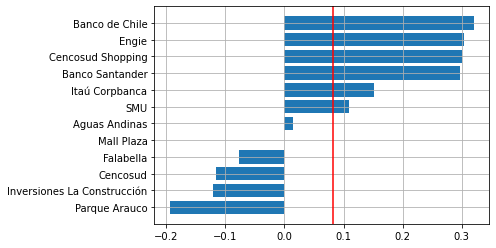

In [11]:
fig = plt.figure()
plt.barh(gp.index, gp['diferencia'], tick_label=gp['nombre'])
plt.axvline(gp['diferencia'].mean(), color='red')
plt.grid()

Luego se calcula un promedio por industria, promediando el isc de las cartas por industria.
- La industria del comercio es la más optimista.
- La de los servicios básicos es la menos optimista.

In [12]:
industrias = presidentes.groupby('industria').mean().reset_index().sort_values(by='isc', ignore_index=True)
industrias.to_csv('05_industrias.csv', index=False, encoding='utf-8-sig')
industrias.sort_values('isc', ascending=False)

,industria,isc
6,Comercio,0.787336
5,Bebidas,0.642982
4,Manufactura,0.606884
3,Tecnología y Transporte,0.593290
2,Energía,0.537576
1,Financiera,0.469674
0,Servicios Básicos,0.410964


A continuación se muestra el cuadro en forma gráfica, junto con la comparación con el promedio de las industrias.

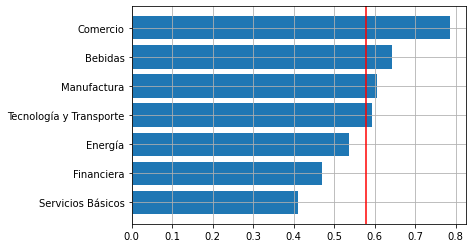

In [13]:
fig = plt.figure()
plt.barh(industrias.index, industrias['isc'], tick_label=industrias['industria'])
plt.axvline(industrias['isc'].mean(), color='red')
plt.grid()

Por último, se muestra el promedio total, correspondiente a todas las empresas del IPSA.

In [14]:
ipsa = presidentes.mean().round(2)
print('Indice IPSA:', ipsa['isc'])

Indice IPSA: 0.59


# Resultados por industria

En esta sección se muestran los ISC por industria, comparando los ISC de empresas que pertenecen a una misma industria o sector económico. Esto es interesante, ya que el nivel promedio de optimismo por industria puede variar, ya que las industrias tienen características idiosincráticas y son afectadas de forma similar por los shocks macroeconómicos, como la pandemia. Así, las diferencias por industria podrían reflejar qué empresas estuvieron mejor preparadas para enfrentar la pandemia de covid19.

En primer lugar se muestra el número de empresas por industria.

In [15]:
presidentes['industria'].value_counts()

Comercio                   7
Financiera                 6
Tecnología y Transporte    4
Energía                    4
Bebidas                    3
Servicios Básicos          3
Manufactura                2
Name: industria, dtype: int64

Luego, se muestra el cuadro de ISC por industria y el gráfico respectivo, donde la línea roja corresponde al promedio por industria.

In [16]:
comercio = presidentes[presidentes['industria']=='Comercio'].sort_values(by='isc', ignore_index=True)
comercio = comercio.drop('industria', axis=1)
comercio = comercio.set_index('nombre')
comercio.to_csv('06_comercio.csv', encoding='utf-8-sig')

print('Más optimista:', comercio['isc'].idxmax())
print('Menos optimista:', comercio['isc'].idxmin())
comercio

Más optimista: Ripley
Menos optimista: Cencosud Shopping


,isc
nombre,
Cencosud Shopping,0.500000
SMU,0.724138
Parque Arauco,0.727273
Mall Plaza,0.764706
Falabella,0.866667
Cencosud,0.928571
Ripley,1.000000


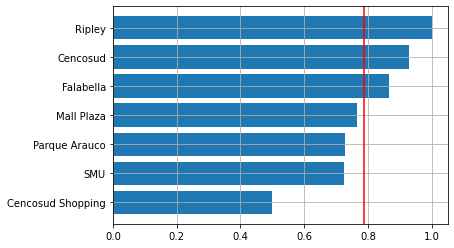

In [17]:
fig = plt.figure()
plt.barh(comercio.index, comercio['isc'])
plt.axvline(comercio['isc'].mean(), color='red')
plt.grid()

In [18]:
financiera = presidentes[presidentes['industria']=='Financiera'].sort_values(by='isc', ignore_index=True)
financiera = financiera.drop('industria', axis=1)
financiera = financiera.set_index('nombre')
financiera.to_csv('07_financiera.csv', encoding='utf-8-sig')

print('Más optimista:', financiera['isc'].idxmax())
print('Menos optimista:', financiera['isc'].idxmin())
financiera

Más optimista: Inversiones La Construcción
Menos optimista: Banco de Chile


,isc
nombre,
Banco de Chile,0.363636
Grupo Security,0.363636
Itaú Corpbanca,0.375000
Banco Santander,0.406250
BCI,0.642857
Inversiones La Construcción,0.666667


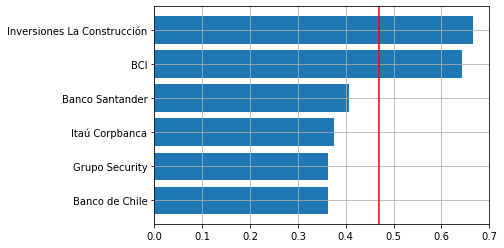

In [19]:
fig = plt.figure()
plt.barh(financiera.index, financiera['isc'])
plt.axvline(financiera['isc'].mean(), color='red')
plt.grid()

In [20]:
energia = presidentes[presidentes['industria']=='Energía'].sort_values(by='isc', ignore_index=True)
energia = energia.drop('industria', axis=1)
energia = energia.set_index('nombre')
energia.to_csv('08_energia.csv', encoding='utf-8-sig')

print('Más optimista:', energia['isc'].idxmax())
print('Menos optimista:', energia['isc'].idxmin())
energia

Más optimista: AES Gener
Menos optimista: Engie


,isc
nombre,
Engie,0.363636
Colbún,0.520000
Enel Américas,0.600000
AES Gener,0.666667


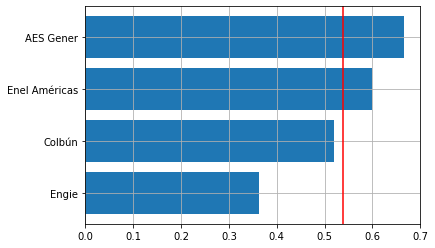

In [21]:
fig = plt.figure()
plt.barh(energia.index, energia['isc'])
plt.axvline(energia['isc'].mean(), color='red')
plt.grid()

In [22]:
tyt = presidentes[presidentes['industria']=='Tecnología y Transporte'].sort_values(by='isc', ignore_index=True)
tyt = tyt.drop('industria', axis=1)
tyt = tyt.set_index('nombre')
tyt.to_csv('09_tyt.csv', encoding='utf-8-sig')

print('Más optimista:', tyt['isc'].idxmax())
print('Menos optimista:', tyt['isc'].idxmin())
tyt

Más optimista: Sonda
Menos optimista: CSAV


,isc
nombre,
CSAV,0.400000
Entel,0.567568
Copec,0.636364
Sonda,0.769231


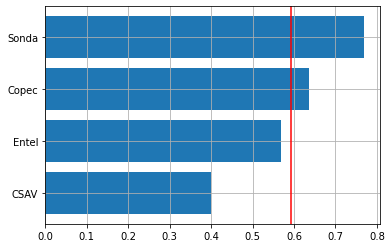

In [23]:
fig = plt.figure()
plt.barh(tyt.index, tyt['isc'])
plt.axvline(tyt['isc'].mean(), color='red')
plt.grid()

In [24]:
servicios = presidentes[presidentes['industria']=='Servicios Básicos'].sort_values(by='isc', ignore_index=True)
servicios = servicios.drop('industria', axis=1)
servicios = servicios.set_index('nombre')
servicios.to_csv('10_servicios.csv', encoding='utf-8-sig')

print('Más optimista:', servicios['isc'].idxmax())
print('Menos optimista:', servicios['isc'].idxmin())
servicios

Más optimista: Enel Chile
Menos optimista: Aguas Andinas


,isc
nombre,
Aguas Andinas,0.384615
Inversiones Aguas Metropolitanas,0.400000
Enel Chile,0.448276


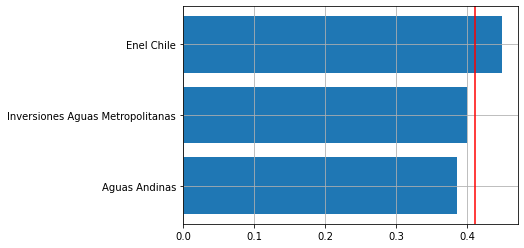

In [25]:

fig = plt.figure()
plt.barh(servicios.index, servicios['isc'])
plt.axvline(servicios['isc'].mean(), color='red')
plt.grid()


In [26]:
bebidas = presidentes[presidentes['industria']=='Bebidas'].sort_values(by='isc', ignore_index=True)
bebidas = bebidas.drop('industria', axis=1)
bebidas = bebidas.set_index('nombre')
bebidas.to_csv('11_bebidas.csv', encoding='utf-8-sig')

print('Más optimista:', bebidas['isc'].idxmax())
print('Menos optimista:', bebidas['isc'].idxmin())
bebidas

Más optimista: Concha y Toro
Menos optimista: CCU


,isc
nombre,
CCU,0.500000
Embotelladora Andina,0.578947
Concha y Toro,0.850000


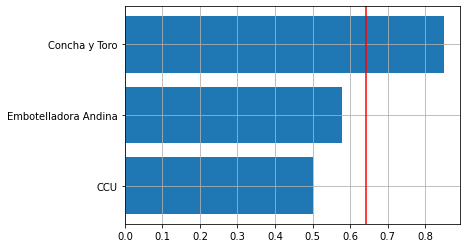

In [27]:
fig = plt.figure()
plt.barh(bebidas.index, bebidas['isc'])
plt.axvline(bebidas['isc'].mean(), color='red')
plt.grid()

In [28]:
manufactura = presidentes[presidentes['industria']=='Manufactura'].sort_values(by='isc', ignore_index=True)
manufactura = manufactura.drop('industria', axis=1)
manufactura = manufactura.set_index('nombre')
manufactura.to_csv('12_manufactura.csv', encoding='utf-8-sig')

print('Más optimista:', manufactura['isc'].idxmax())
print('Menos optimista:', manufactura['isc'].idxmin())
manufactura

Más optimista: CMPC
Menos optimista: CAP


,isc
nombre,
CAP,0.583333
CMPC,0.630435


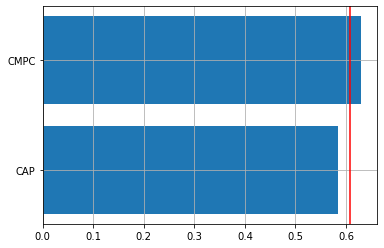

In [29]:
fig = plt.figure()
plt.barh(manufactura.index, manufactura['isc'])
plt.axvline(manufactura['isc'].mean(), color='red')
plt.grid()

# Próximos pasos

## ¿Qué significa el sentimiento corporativo? ¿Qué significa el sentimiento económico, en general?

El significado o las implicancias de los índices presentados son desconocidas, y deben ser materia de futuros estudios. 
Sería interesante responder preguntas como: 
- ¿Se puede predecir el desempeño futuro de las empresas o industrias a partir de esta información (ventas, utilidades, precios de las acciones)? 
- ¿Se puede predecir el retorno del IPSA? 
- ¿Se puede predecir la actividad económica, consumo, inversión, empleo u otras variables macroeconómicas? 

## Extensiones del estudio

Se podría profundizar el desarrollo de este índice, construyendo indicadores adicionales a partir de la información que se tiene actualmente, por ejemplo: 
- crear índices de dispersión que midan incertidumbre.
- entrenar el modelo para identificar textos negativos y luego construir un índice de difusión.
- extender el análisis a un conjunto más amplio de empresas (IGPA) o de años.


## Indice de incertidumbre político-económica

Sería interesar usar el modelo de machine learning desarrollado en este estudio para analizar el sentimiento de otros textos económicos. 

Por ejemplo, para identificar el sentimiento de las noticias de la prensa online, como lo hacen los índices de incertidumbre político-económica, la actividad de redes sociales como Twitter o los textos del Informe de Percepciones de Negocios del Banco Central de Chile. 